# Image classification of cardiomyocyte tissues

This pipeline classifies cardiomyocyte images to distinguish issues from patients with chronic heart failure from ones from health donnors. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. The images downloaded from https://idr.openmicroscopy.org/webclient/?show=project-402 processed with the following:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This pipeline follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

It is always a good idea to import packages separately to minimise their impact on compatibility.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Download the dataset idr0042 with the OMERO 5.6.1 JSON API https://docs.openmicroscopy.org/omero/5.6.1/developers/json-api.html. The dataset is stored in the "/tmp/" directory for training and verification.

In [4]:
################################
# Create a session to access IDR
################################
import requests


def get_session() -> requests.Session:
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL

    # create http session
    with requests.Session() as session:
        request = requests.Request('GET', INDEX_PAGE)
        prepped = session.prepare_request(request)
        response = session.send(prepped)
        if response.status_code != 200:
            response.raise_for_status()
    return session

In [5]:
######################
# Access test data set
######################
# import json
# from IPython.display import display, HTML
import os
import tensorflow as tf

OUTPUT_PATH = '/tmp'


def download_img(ds_id: str, session: requests.Session, output_path: str = OUTPUT_PATH):
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    DS_IMG_URI = "{base}/api/v0/m/datasets/{dataset_id}/images/?limit=2500"         # test 1155, training 1144
    IMG_RDR_URI = "{base}/webgateway/render_image/{image_id}/0/0/"
    IMG_ANNO_URI = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

    qs_ds = {'base': IDR_BASE_URL, 'dataset_id': ds_id}
    r = session.get(DS_IMG_URI.format(**qs_ds))
    # print('HTTP status for image:', r.status_code)
    if r.status_code == 200:
        #     print (json.dumps(r.json()['data'][:1], indent=2, sort_keys=True))
        for img in r.json()['data']:    # [:2]:
            img_name = img['Name']
            img_id = img['@id']
            img_path = ''

            qs_img = {'base': IDR_BASE_URL, 'image_id': img_id}
            # display(HTML("<img src='%s' />" % IMG_RDR_URI.format(**qs_img)))

            qs_anno = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': img_id}
            r_anno = session.get(IMG_ANNO_URI.format(**qs_anno))
            # print('HTTP status for annotation:', r_anno.status_code)
            for a in r_anno.json()['annotations']:
                for v in a['values']:
                    key = v[0]
                    value = v[1]
                    print(key, ':', value)

                    if key == 'Diagnosis' and value != 'heart tissue pathology':
                        path = os.path.join(output_path, value.replace(" ", "_"))
                        if not os.path.exists(path):
                            os.system("mkdir -p " + path)
                        img_path = tf.keras.utils.get_file(fname=os.path.join(path, img_name), origin=IMG_RDR_URI.format(**qs_img))
            print(img_name, img_id, img_path)
            print('')       # pretty print
    return output_path


# dataset IDs
DS_TEST_ID = "827"
DS_TRAIN_ID = "828"

validation_dir: str = download_img(ds_id=DS_TEST_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'validation'))
train_dir: str = download_img(ds_id=DS_TRAIN_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'train'))

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_1_0.png 3428066 /tmp/validation/chronic_heart_failure/33375_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_20_0.png 3428067 /tmp/validation/chronic_heart_failure/33375_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_23_0.png 3428068 /tmp/validation/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_20_0.png 3428095 /tmp/validation/chronic_heart_failure/33388_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_2_0.png 3428098 /tmp/validation/chronic_heart_failure/33388_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_23_0.png 3428096 /tmp/validation

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 33395
Clinical History : non-ischemic cardiomyopathy
33395_0_fal_25_0.png 3428125 /tmp/validation/chronic_heart_failure/33395_0_fal_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 33395
Clinical History : non-ischemic cardiomyopathy
33395_0_fal_3_0.png 3428129 /tmp/validation/chronic_heart_failure/33395_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 33395
Clinical History : non-ischemic cardiomyopathy
33395_0_fal_33_0.png 3428126 /tmp/validation/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 42 years
Individual : 33402
Clinical History : ischemic cardiomyopathy
33402_0_fal_1_0.png 3428159 /tmp/validation/chronic_heart_failure/33402_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 42 years
Individual : 33402
Clinical History : ischemic cardiomyopathy
33402_0_fal_11_0.png 3428154 /tmp/validation/chronic_heart_failure/33402_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 42 years
Individual : 33402
Clinical History : ischemic cardiomyopathy
33402

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_20_0.png 3428180 /tmp/validation/chronic_heart_failure/33407_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_23_0.png 3428181 /tmp/validation/chronic_heart_failure/33407_0_fal_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_25_0.png 3428182 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_1_0.png 3428211 /tmp/validation/chronic_heart_failure/33414_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_11_0.png 3428209 /tmp/validation/chronic_heart_failure/33414_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_13_0.png 34

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_44_0.png 3428237 /tmp/validation/chronic_heart_failure/33417_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_48_0.png 3428238 /tmp/validation/chronic_heart_failure/33417_0_fal_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_50_0.p

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
33424_0_fal_15_0.png 3428265 /tmp/validation/chronic_heart_failure/33424_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
33424_0_fal_19_0.png 3428266 /tmp/validation/chronic_heart_failure/33424_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
334

Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_46_0.png 3428294 /tmp/validation/chronic_heart_failure/33467_0_fal_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_6_0.png 3428295 /tmp/validation/chronic_heart_failure/33467_0_fal_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_8_0.png 3428296 /tmp/validation/chronic_heart_failure/33467_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : fem

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33476
Clinical History : non-ischemic cardiomyopathy
33476_0_fal_27_0.png 3428322 /tmp/validation/chronic_heart_failure/33476_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33476
Clinical History : non-ischemic cardiomyopathy
33476_0_fal_33_0.png 3428323 /tmp/validation/chronic_heart_failure/33476_0_fal_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33476
Clinical History : non-ischemic cardiomyopathy
33476_0_fal_4_0.png 3428324 /tmp/val

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 years
Individual : 33482
Clinical History : ischemic cardiomyopathy
33482_0_fal_1_0.png 3428360 /tmp/validation/chronic_heart_failure/33482_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 years
Individual : 33482
Clinical History : ischemic cardiomyopathy
33482_0_fal_11_0.png 3428353 /tmp/validation/chronic_heart_failure/33482_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 years
Individual : 33482
Clinical History : ischemic cardiomyopathy
33482_0_fal_12_0.png 34

Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_30_0.png 3428380 /tmp/validation/chronic_heart_failure/33490_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_34_0.png 3428381 /tmp/validation/chronic_heart_failure/33490_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_40_0.png 3428382 /tmp/validation/chronic_heart_failure/33490_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Di

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 33539
Clinical History : ischemic cardiomyopathy
33539_0_fal_19_0.png 3428411 /tmp/validation/chronic_heart_failure/33539_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 33539
Clinical History : ischemic cardiomyopathy
33539_0_fal_25_0.png 3428412 /tmp/validation/chronic_heart_failure/33539_0_fal_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 33539
Clinical History : ischemic cardiomyopathy
33539_0_fal_29_0.png 3428413 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33546
Clinical History : non-ischemic cardiomyopathy
33546_0_fal_22_0.png 3428441 /tmp/validation/chronic_heart_failure/33546_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33546
Clinical History : non-ischemic cardiomyopathy
33546_0_fal_23_0.png 3428442 /tmp/validation/chronic_heart_failure/33546_0_fal_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33546
Clinical History : non-ischemic cardiomyopathy
33546_0_fal_25_0.p

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_42_0.png 3428468 /tmp/validation/chronic_heart_failure/33549_0_fal_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_44_0.png 3428469 /tmp/validation/chronic_heart_failure/33549_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_49_0.png 3428470 /tmp/validation/chronic_heart_failure/33549_0_fal_49_0.png

Organism : Ho

Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 years
Individual : 34073
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34073_1_nrm_13_0.png 3428498 /tmp/validation/not_chronic_heart_failure/34073_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 years
Individual : 34073
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34073_1_nrm_14_0.png 3428499 /tmp/validation/not_chronic_heart_failure/34073_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 years
Individual : 34073


Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_11_0.png 3428529 /tmp/validation/chronic_heart_failure/34077_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_17_0.png 3428530 /tmp/validation/chronic_heart_failure/34077_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_19_0.png 3428531 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 34085
Clinical History : non-ischemic cardiomyopathy
34085_0_fal_47_0.png 3428559 /tmp/validation/chronic_heart_failure/34085_0_fal_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 34085
Clinical History : non-ischemic cardiomyopathy
34085_0_fal_48_0.png 3428560 /tmp/validation/chronic_heart_failure/34085_0_fal_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function


Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_13_0.png 3428585 /tmp/validation/chronic_heart_failure/34089_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_14_0.png 3428586 /tmp/validation/chronic_heart_failure/34089_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_15_0.png 3428587 /tmp/validation/chroni

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_10_0.png 3428616 /tmp/validation/chronic_heart_failure/34231_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_1_0.png 3428620 /tmp/validation/chronic_heart_failure/34231_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_13_0.png 3428617 /tmp/v

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_2_0.png 3428648 /tmp/validation/chronic_heart_failure/34281_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_22_0.png 3428646 /tmp/validation/chronic_heart_failure/34281_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_26_0.png 3428647 /tmp/validation/chronic_heart_failure/34281_0_fal_2

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35590_1_nrm_25_0.png 3428673 /tmp/validation/not_chronic_heart_failure/35590_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35590_1_nrm_27_0.png 3428674 /tmp/validation/not_chronic_heart_failure/35590_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical Histor

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 35594
Clinical History : normal cardiovascular function by cardiac catheterization
35594_1_nrm_8_0.png 3428703 /tmp/validation/not_chronic_heart_failure/35594_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_10_0.png 3428704 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chron

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_40_0.png 3428733 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_42_0.png 3428734 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_19_0.png 3428763 /tmp/validation/not_chronic_heart_failure/35606_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_20_0.png 3428764 /tmp/validation/not_chronic_heart_failure/35606_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_22_0.png 3428765 /tmp/validation/not_

Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical History : normal cardiovascular function by cardiac catheterization
35609_1_nrm_40_0.png 3428790 /tmp/validation/not_chronic_heart_failure/35609_1_nrm_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical History : normal cardiovascular function by cardiac catheterization
35609_1_nrm_6_0.png 3428791 /tmp/validation/not_chronic_heart_failure/35609_1_nrm_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35622
Clinical History : normal cardiovascular function by cardiac catheterization
35622_1_nrm_12_0.png 3428792 /tmp/validation/not_chronic_heart_failure/35622_1_nrm_12_0.png

Organism : Homo sapiens
Channels :

Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35626_1_nrm_18_0.png 3428820 /tmp/validation/not_chronic_heart_failure/35626_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35626_1_nrm_19_0.png 3428821 /tmp/validation/not_chronic_heart_failure/35626_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal c

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35630
Clinical History : normal cardiovascular function by cardiac catheterization
35630_1_nrm_28_0.png 3428852 /tmp/validation/not_chronic_heart_failure/35630_1_nrm_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35630
Clinical History : normal cardiovascular function by cardiac catheterization
35630_1_nrm_30_0.png 3428853 /tmp/validation/not_chronic_heart_failure/35630_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35630
Clinical History : normal cardiovascular function by cardiac catheterization
35630_1_nrm_4_0.png 3428857 /tmp/validation/no

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35637
Clinical History : normal cardiovascular function by cardiac catheterization
35637_1_nrm_2_0.png 3428883 /tmp/validation/not_chronic_heart_failure/35637_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35637
Clinical History : normal cardiovascular function by cardiac catheterization
35637_1_nrm_24_0.png 3428881 /tmp/validation/not_chronic_heart_failure/35637_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35637
Clinical History : normal cardiovascular function by cardiac catheterization
35637_1_nrm_28_0.png 342888

Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 35643
Clinical History : normal cardiovascular function by cardiac catheterization
35643_1_nrm_51_0.png 3428912 /tmp/validation/not_chronic_heart_failure/35643_1_nrm_51_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35644
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35644_1_nrm_1_0.png 3428921 /tmp/validation/not_chronic_heart_failure/35644_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35644
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35644_1_nrm_11_0.png 34

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35649
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35649_1_nrm_51_0.png 3428943 /tmp/validation/not_chronic_heart_failure/35649_1_nrm_51_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35649
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35649_1_nrm_7_0.png 3428944 /tmp/validation/not_chronic_heart_failure/35649_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_12_0.png 3428970 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_13_0.png 3428971 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical Histor

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 21 years
Individual : 36114
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36114_1_nrm_9_0.png 3429000 /tmp/validation/not_chronic_heart_failure/36114_1_nrm_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36116_1_nrm_10_0.png 3429001 /tmp/validation/not_chronic_heart_failure/36116_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical Hi

Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_43_0.png 3429031 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_45_0.png 3429032 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of ch

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_35_0.png 3429062 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_38_0.png 3429063 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical 

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_50_0.png 3429626 /tmp/train/chronic_heart_failure/33383_0_fal_50_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_9_0.png 3429627 /tmp/train/chronic_heart_failure/33383_0_fal_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33385
Clinical History : ischemic cardiomyopathy
33385_0_fal_1_0.png 3429224 /tmp/train/chronic_heart_failure/33385_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagno

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_45_0.png 3429645 /tmp/train/chronic_heart_failure/33392_0_fal_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_47_0.png 3429646 /tmp/train/chronic_heart_failure/33392_0_fal_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_5_0.png 3429648 /tmp/train/chronic_heart_failure/33392_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diag

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_43_0.png 3429237 /tmp/train/chronic_heart_failure/33398_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_46_0.png 3429238 /tmp/train/chronic_heart_failure/33398_0_fal_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_5_0.png 3429240 /tmp/train/chronic_heart_failure/33398_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_12_0.png 3429255 /tmp/train/chronic_heart_failure/33410_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_16_0.png 3429256 /tmp/train/chronic_heart_failure/33410_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_17_0.png 3429257 /tmp/train/chronic_hear

Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_8_0.png 3429704 /tmp/train/chronic_heart_failure/33412_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33413
Clinical History : ischemic cardiomyopathy
33413_0_fal_12_0.png 3429705 /tmp/train/chronic_heart_failure/33413_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33413
Clinical History : ischemic cardiomyopathy
33413_0_fal_13_0.png 3429706 /tmp/train/chronic_heart_failure/33413_0_fal_13_0.png

Organism : Homo sapiens
Channel

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33418
Clinical History : ischemic cardiomyopathy
33418_0_fal_5_0.png 3429735 /tmp/train/chronic_heart_failure/33418_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33418
Clinical History : ischemic cardiomyopathy
33418_0_fal_6_0.png 3429736 /tmp/train/chronic_heart_failure/33418_0_fal_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33418
Clinical History : ischemic cardiomyopathy
33418_0_fal_8_0.png 3429737 /tmp/train/chronic_heart_fai

Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years
Individual : 33422
Clinical History : non-ischemic cardiomyopathy
33422_0_fal_30_0.png 3429754 /tmp/train/chronic_heart_failure/33422_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years
Individual : 33422
Clinical History : non-ischemic cardiomyopathy
33422_0_fal_3_0.png 3429755 /tmp/train/chronic_heart_failure/33422_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years
Individual : 33422
Clinical History : non-ischemic cardiomyopathy
33422_0_fal_40_0.png 3429756 /tmp/train/chronic_heart_failure/33422_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Or

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_11_0.png 3429761 /tmp/train/chronic_heart_failure/33471_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_12_0.png 3429762 /tmp/train/chronic_heart_failure/33471_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_14_0.png 3429763 /tmp/train/chronic_heart_failure/33471_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Di

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clinical History : ischemic cardiomyopathy
33478_0_fal_9_0.png 3429792 /tmp/train/chronic_heart_failure/33478_0_fal_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_10_0.png 3429793 /tmp/train/chronic_heart_failure/33479_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_16_0.png 3429794 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_15_0.png 3429819 /tmp/train/chronic_heart_failure/33485_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_16_0.png 3429820 /tmp/train/chronic_heart_failure/33485_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_2_0.png 3429825 /tmp/train/chronic_heart

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_2_0.png 3429854 /tmp/train/chronic_heart_failure/33489_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_21_0.png 3429851 /tmp/train/chronic_heart_failure/33489_0_fal_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_23_0.png 3429852 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_13_0.png 3429871 /tmp/train/chronic_heart_failure/33543_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_22_0.png 3429872 /tmp/train/chronic_heart_failure/33543_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_23_0.png 3429873

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_41_0.png 3429900 /tmp/train/chronic_heart_failure/33547_0_fal_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_47_0.png 3429901 /tmp/train/chronic_heart_failure/33547_0_fal_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 69 years
Individual : 33550
Clinical History : non-ischemic cardiomyopathy
33550_0_fal_11_0.png 3429309

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinical History : ischemic cardiomyopathy
33552_0_fal_29_0.png 3429906 /tmp/train/chronic_heart_failure/33552_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinical History : ischemic cardiomyopathy
33552_0_fal_3_0.png 3429909 /tmp/train/chronic_heart_failure/33552_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinical History : ischemic cardiomyopathy
33552_0_fal_33_0.png 3429907 /tmp/train/chronic_heart_failure/33552_0_fal_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diag

Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33555
Clinical History : ischemic cardiomyopathy
33555_0_fal_18_0.png 3429343 /tmp/train/chronic_heart_failure/33555_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33555
Clinical History : ischemic cardiomyopathy
33555_0_fal_19_0.png 3429344 /tmp/train/chronic_heart_failure/33555_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33555
Clinical History : ischemic cardiomyopathy
33555_0_fal_20_0.png 3429345 /tmp/tra

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 46 years
Individual : 34078
Clinical History : non-ischemic cardiomyopathy
34078_0_fal_43_0.png 3429934 /tmp/train/chronic_heart_failure/34078_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 46 years
Individual : 34078
Clinical History : non-ischemic cardiomyopathy
34078_0_fal_46_0.png 3429935 /tmp/train/chronic_heart_failure/34078_0_fal_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_1_0.png 3429937 /tmp/train/chronic_heart_failure/3

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_34_0.png 3429368 /tmp/train/chronic_heart_failure/34082_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_37_0.png 3429369 /tmp/train/chronic_heart_failure/34082_0_fal_37_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_42_0.png 3429370 /tmp/train/chronic_heart_failure/34082

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_1_0.png 3429388 /tmp/train/chronic_heart_failure/34277_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_13_0.png 3429387 /tmp/train/chronic_heart_failure/34277_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_21_0.png 3429389 /tmp/train/chronic_heart_failure/34277_0_fal_21_0.png



Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 65 years
Individual : 35591
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35591_1_nrm_7_0.png 3429990 /tmp/train/not_chronic_heart_failure/35591_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_17_0.png 3429991 /tmp/train/not_chronic_heart_failure/35593_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterizati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_32_0.png 3430007 /tmp/train/not_chronic_heart_failure/35598_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_43_0.png 3430008 /tmp/train/not_chronic_heart_failure/35598_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : don

Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_22_0.png 3429421 /tmp/train/not_chronic_heart_failure/35605_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_25_0.png 3429422 /tmp/train/not_chronic_heart_failure/35605_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_29_0.png 3429423 /tmp/trai

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_25_0.png 3430046 /tmp/train/not_chronic_heart_failure/35624_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_28_0.png 3430047 /tmp/train/not_chronic_heart_failure/35624_1_nrm_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_3_0.png 3430053 /tmp/tr

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35631_1_nrm_19_0.png 3429449 /tmp/train/not_chronic_heart_failure/35631_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35631_1_nrm_20_0.png 3429451 /tmp/train/not_chronic_heart_failure/35631_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 34 years
Individual : 35633
Clinical History : do

Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_24_0.png 3430082 /tmp/train/not_chronic_heart_failure/35636_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_29_0.png 3430083 /tmp/train/not_chronic_heart_failure/35636_1_nrm_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_32_0.png 3430084 /tmp/train/not_chronic_heart_failure/35636_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagno

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 35642
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35642_1_nrm_11_0.png 3430102 /tmp/train/not_chronic_heart_failure/35642_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 35642
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35642_1_nrm_12_0.png 3430103 /tmp/train/not_chronic_heart_failure/35642_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 35642
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 35647
Clinical History : normal cardiovascular function by cardiac catheterization
35647_1_nrm_19_0.png 3430132 /tmp/train/not_chronic_heart_failure/35647_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 35647
Clinical History : normal cardiovascular function by cardiac catheterization
35647_1_nrm_2_0.png 3430133 /tmp/train/not_chronic_heart_failure/35647_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
3564

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35876_1_nrm_14_0.png 3430159 /tmp/train/not_chronic_heart_failure/35876_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35876_1_nrm_15_0.png 3430160 /tmp/train/not_chronic_heart_failure/35876_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor 

Sex : male
Ethnic or Racial Group : Caucasian
Age : 1 year
Individual : 35881
Clinical History : normal cardiovascular function by cardiac catheterization
35881_1_nrm_12_0.png 3429464 /tmp/train/not_chronic_heart_failure/35881_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 1 year
Individual : 35881
Clinical History : normal cardiovascular function by cardiac catheterization
35881_1_nrm_18_0.png 3429465 /tmp/train/not_chronic_heart_failure/35881_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 1 year
Individual : 35881
Clinical History : normal cardiovascular function by cardiac catheterization
35881_1_nrm_26_0.png 3429466 /tmp/train/not_chronic_heart_failure/35881_1_nrm_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 36112
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36112_1_nrm_28_0.png 3430209 /tmp/train/not_chronic_heart_failure/36112_1_nrm_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36118
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36118_1_nrm_1_0.png 3429477 /tmp/train/not_chronic_heart_failure/36118_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36118
Clinical History : donor wit

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36124
Clinical History : normal cardiovascular function by cardiac catheterization
36124_1_nrm_43_0.png 3430230 /tmp/train/not_chronic_heart_failure/36124_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36124
Clinical History : normal cardiovascular function by cardiac catheterization
36124_1_nrm_47_0.png 3430231 /tmp/train/not_chronic_heart_failure/36124_1_nrm_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36124
Clinical History : normal cardiovascular function by cardiac catheterization
36124_1_nrm_6_0.png 3430232 /tmp/train/not_chronic_heart

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36130_1_nrm_45_0.png 3429503 /tmp/train/not_chronic_heart_failure/36130_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36130_1_nrm_49_0.png 3429504 /tmp/train/not_chronic_heart_failure/36130_1_nrm_49_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : 

Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36134_1_nrm_24_0.png 3430270 /tmp/train/not_chronic_heart_failure/36134_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36134_1_nrm_29_0.png 3430271 /tmp/train/not_chronic_heart_failure/36134_1_nrm_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular fu

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_18_0.png 3429519 /tmp/train/not_chronic_heart_failure/36144_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_21_0.png 3429521 /tmp/train/not_chronic_heart_failure/36144_1_nrm_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_23_0.png 3429522 /tmp/train/not_chronic_hear

After extracting its contents, assign variables with the proper file path for the training and validation set.

### Understand the data

Inspect the training and validation directoris to help understanding what has been downloaded: slides of cardiomyocyte tissues from healthy donnors and patients with chronic heart failure.

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [6]:
#####################
# Understand the data
#####################
train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total = total_train + total_val

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total images:", total)

Total training failure images: 517
Total training healthy images: 483
Total validation failure images: 517
Total validation healthy images: 461
Total training images: 1000
Total validation images: 978
Total images: 1978


In [7]:
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 978 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator then plot five of them with `matplotlib`.

The module pillow seems missing from the Google Notebook image.

In [11]:
!pip3 install pillow --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

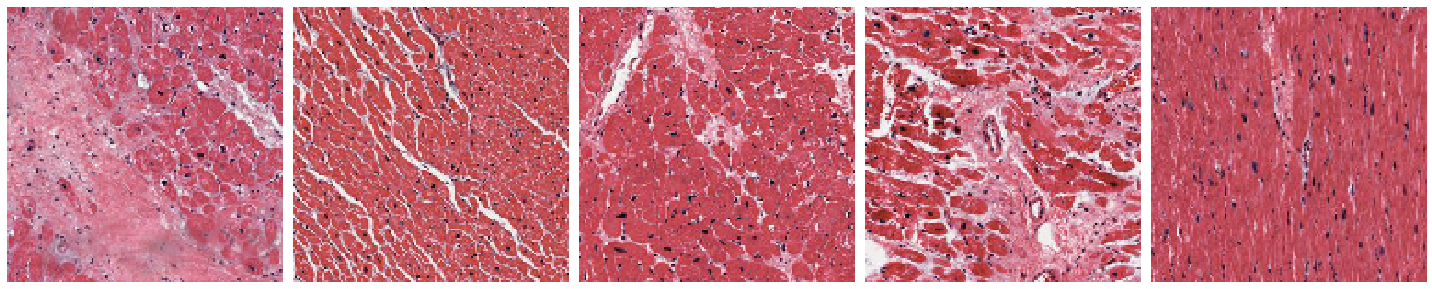

In [14]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [15]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

As all the other black magic in ML, the *ADAM* optimizer and *binary cross entropy* loss function are used here. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/25
7/7 [==============================] - 15s 2s/step - loss: 1.0806 - accuracy: 0.4530 - val_loss: 0.6995 - val_accuracy: 0.5357
Epoch 2/25
7/7 [==============================] - 15s 2s/step - loss: 0.6942 - accuracy: 0.5275 - val_loss: 0.6898 - val_accuracy: 0.5357
Epoch 3/25
7/7 [==============================] - 14s 2s/step - loss: 0.6903 - accuracy: 0.5206 - val_loss: 0.6854 - val_accuracy: 0.5357
Epoch 4/25
7/7 [==============================] - 15s 2s/step - loss: 0.6858 - accuracy: 0.5190 - val_loss: 0.6747 - val_accuracy: 0.5357
Epoch 5/25
7/7 [==============================] - 14s 2s/step - loss: 0.6704 - accuracy: 0.5413 - val_loss: 0.6957 - val_accuracy: 0.6205
Epoch 6/25
7/7 [==============================] - 15s 2s/step - loss: 0.6574 - accuracy: 0.5998 - val_loss: 0.6473 - val_accuracy: 0.5469
Epoch 

### Visualize training results

Now visualize the results after training the network.

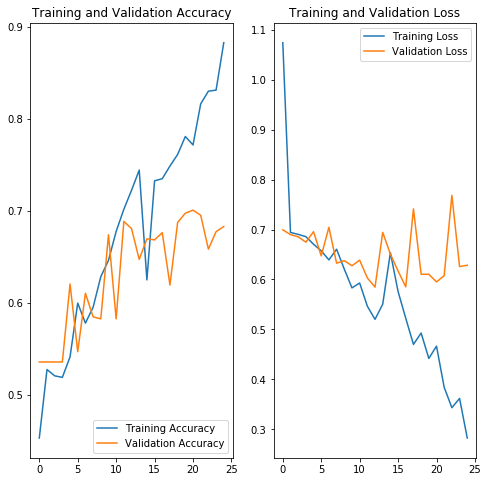

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy and validation accuracy are off by large margin and the model has achieved only around **75%** accuracy on the validation set while the training set is well on its way to **85%**. If given more epochs, the accuracy will diverge further. So does the loss.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. The *data augmentation* and *dropout* are popular techniques to overcome that.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training examples by augmenting them with random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [21]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

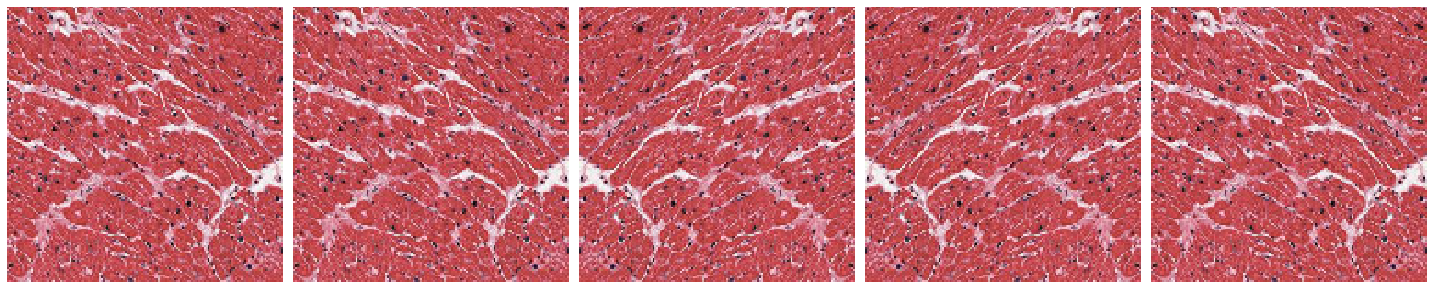

In [23]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Apply 45 degrees of rotation randomly to the training samples as another augmentation.

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [25]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


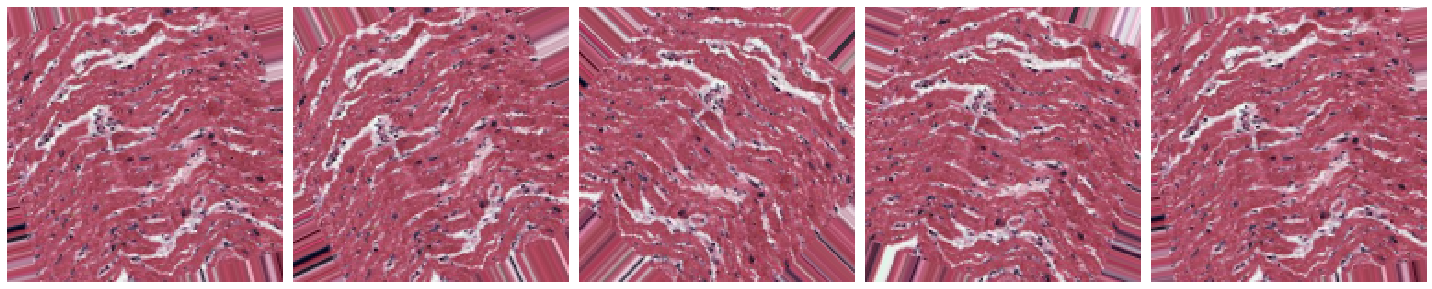

In [26]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [27]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [28]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


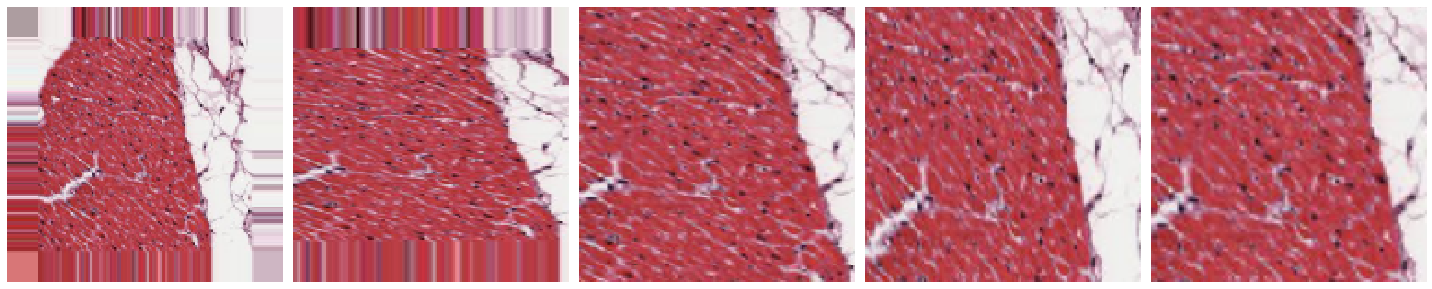

In [29]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations: rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [30]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [31]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 1000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

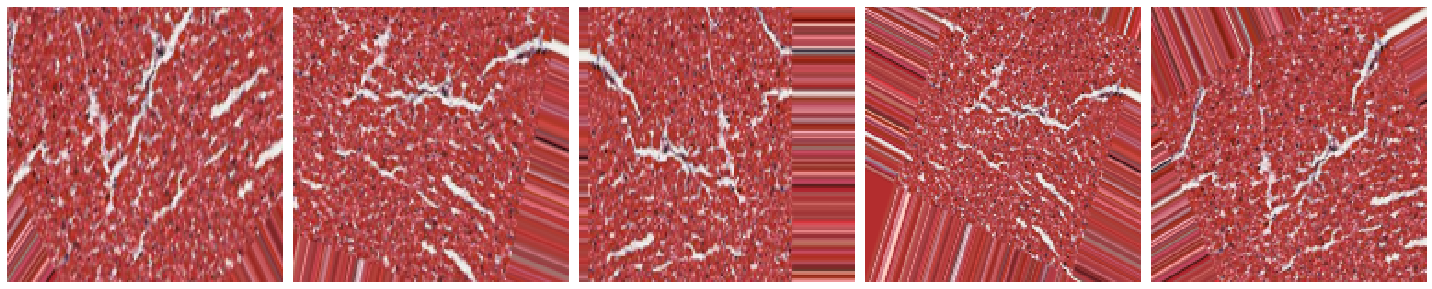

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [33]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [34]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 978 images belonging to 2 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in multiple ML scenarios, including image classification.

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset. And of course, it could also forget useful knowledge.

In [35]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [36]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [37]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/25
7/7 [==============================] - 17s 2s/step - loss: 1.6756 - accuracy: 0.5023 - val_loss: 0.7535 - val_accuracy: 0.4442
Epoch 2/25
7/7 [==============================] - 17s 2s/step - loss: 0.7281 - accuracy: 0.5011 - val_loss: 0.6917 - val_accuracy: 0.5290
Epoch 3/25
7/7 [==============================] - 17s 2s/step - loss: 0.6895 - accuracy: 0.5183 - val_loss: 0.6906 - val_accuracy: 0.5312
Epoch 4/25
7/7 [==============================] - 16s 2s/step - loss: 0.6791 - accuracy: 0.5493 - val_loss: 0.6700 - val_accuracy: 0.5837
Epoch 5/25
7/7 [==============================] - 17s 2s/step - loss: 0.6678 - accuracy: 0.5631 - val_loss: 0.6686 - val_accuracy: 0.6406
Epoch 6/25
7/7 [==============================] - 17s 2s/step - loss: 0.6394 - accuracy: 0.6124 - val_loss: 0.7118 - val_accuracy: 0.6217
Epoch 7/25
7/7 [==============================] - 17s 2s/step - loss: 0.6152 - acc

### Visualize the model

Visualize the new model after training. There is significantly less overfitting than before. The accuracy suffers slightly. However, there is no divergence in either accuracy or loss in training and verification data sets.

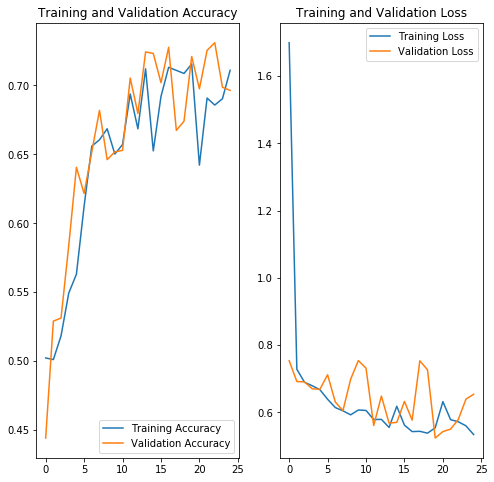

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()